# Курсовой проект по курсу "Библиотеки Python для Data Science: продолжение"

### Постановка задачи
### Задача

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

### Метрика качества

F1-score (sklearn.metrics.f1_score)

### Требования к решению

*Целевая метрика*

- F1(𝛽 = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
- Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1) Тетрадку Jupyter Notebook GurbanovIM_solution.ipynb

2) Файл CSV с прогнозами целевой переменной для тестового датасета GurbanovIM_predictions.csv

*Рекомендации для файла с кодом (ipynb)*

1) Файл должен содержать заголовки и комментарии (markdown)

2) Повторяющиеся операции лучше оформлять в виде функций

3) Не делать вывод большого количества строк таблиц (5-10 достаточно)

4) По возможности добавлять графики, описывающие данные (около 3-5)

5) Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта

6) Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)

7) Весь проект должен быть в одном скрипте (файл ipynb).

8) Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно  в течение 5 дней после окончания последнего вебинара. 
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета +
2. Обработка выбросов +
3. Обработка пропусков +
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Курсовой проект

**Импорт библиотек**

In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import catboost as catb
import scipy.stats as stats


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

%matplotlib inline

**Загрузка данных**

In [10]:
os.chdir('/Users/gurbanovsmac/desktop/course_project/')

In [11]:
ls

course_project_test.csv   course_project_train.csv


In [12]:
TRAIN_DATASET_PATH = '/Users/gurbanovsmac/desktop/course_project/course_project_train.csv'
TEST_DATASET_PATH = '/Users/gurbanovsmac/desktop/course_project/course_project_test.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

**Целевая переменная**

In [13]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

In [14]:
y = df_train[[TARGET_NAME]]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


Распределение значений целевой переменной

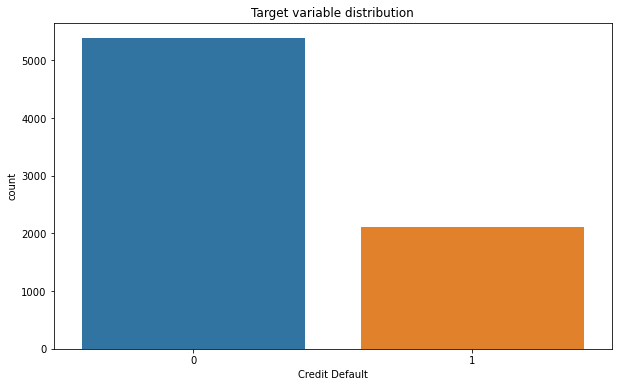

In [16]:
plt.figure(figsize=(10, 6))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Обзор обучающего датасета**

*Описание датасета*

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [17]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


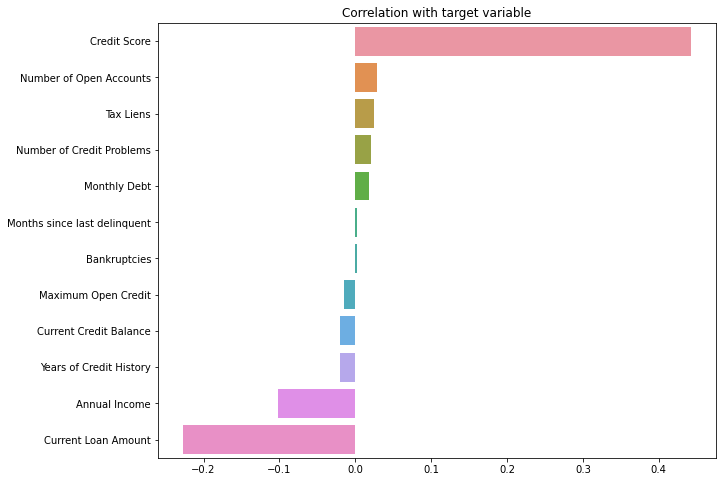

In [20]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

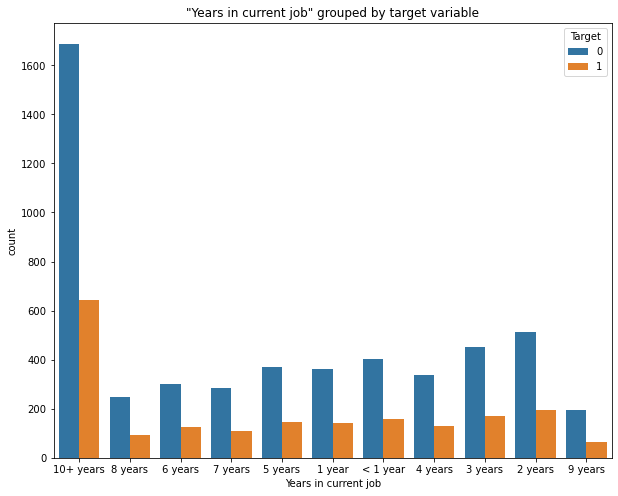

In [21]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('\"Years in current job\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

*Выводы для дальнейшего анализа датасета:*

- Пропуски в "Months since last delinquent" возможно показывают, что на текущий момент просроченная задолжность отсутствует. NaN заменяется 0. Добавляется новый бинарный признак - 1/0 (задолженость/отсутствие задолженности).

- Пропуски в "Annual Income" могут свидетельствовать о неизвестном доходе. Данный критерий важен для анализа платежеспособности заемщика. Пропуски заменяются на медиану и определяется новое значение 0 (неизвестный доход).

- Значение 99999999 в признаке "Current Loan Amount" вызывает сомнение в его корректости. Скорее всего это выброс.

**Обработка выбросов и пропусков**

In [22]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [23]:
df_train['has_delay'] = 1
df_train.loc[(df_train['Months since last delinquent'] == 0), 'has_delay'] = 0
df_train['Months since last delinquent'].fillna(0, inplace=True)

In [24]:
df_train['unknown_income'] = 0
df_train.loc[(df_train['Annual Income'].isnull()), 'unknown_income'] = 1
annual_income_median = df_train['Annual Income'].median()
df_train['Annual Income'].fillna(annual_income_median, inplace=True)

In [25]:
df_train.isnull().sum()
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,1,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,1,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,1,0
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1,1,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0,1,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1,1,0
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0,1,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1,1,1


In [26]:
NEW_FEATURE_NAMES = ['has_delay','unknown_income']

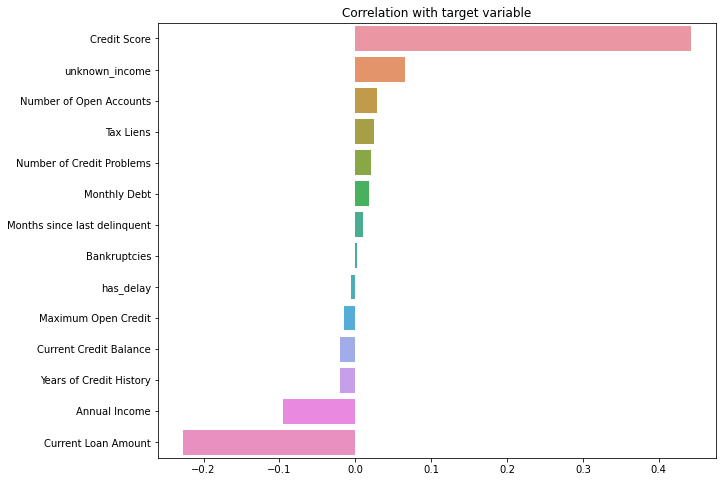

In [27]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Анализ данных. Отбор признаков. Балансировка классов**

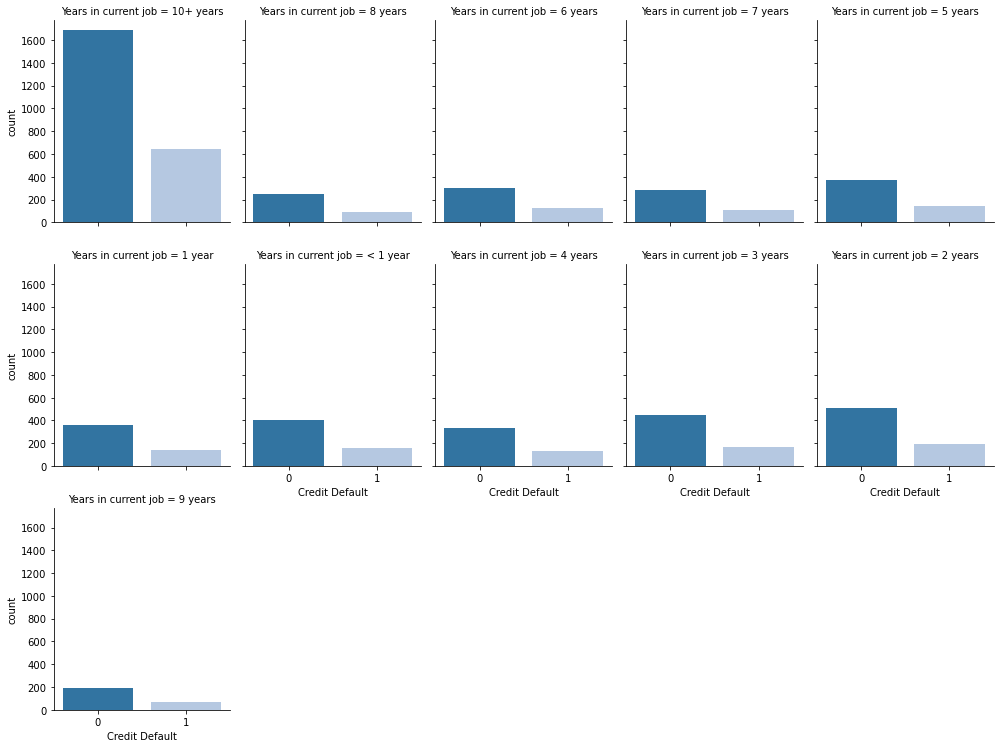

In [30]:
g = sns.catplot("Credit Default", col="Years in current job", col_wrap=5,
                data=df_train,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')
plt.show()

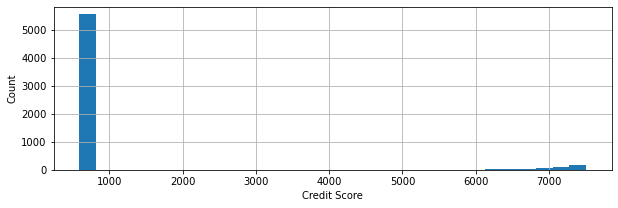

In [32]:
plt.figure(figsize = (10, 3))

df_train['Credit Score'].hist(bins=30, )
plt.ylabel('Count')
plt.xlabel('Credit Score')

plt.show()

In [33]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
has_delay                          0
unknown_income                     0
dtype: int64

Обработка 'Credit Score'

In [34]:
df_train['unknown_credit_score'] = 0

NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']

credit_score_median = df_train['Credit Score'].median()

df_train.loc[(df_train['Credit Score'].isnull()), 'unknown_credit_score'] = 1

df_train['Credit Score'].fillna(credit_score_median, inplace=True)

Обработка Years in current job

In [35]:
import random

unique_years_in_current_job = df_train['Years in current job'].unique()

var_experiance = unique_years_in_current_job[1:]

df_train['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

In [36]:
df_train.isnull().sum()

Home Ownership                   0
Annual Income                    0
Years in current job             0
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     0
Bankruptcies                    14
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
Credit Default                   0
has_delay                        0
unknown_income                   0
unknown_credit_score             0
dtype: int64

In [37]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income,unknown_credit_score
0,Own Home,482087.0,4 years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,1,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,1,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,1,0,0
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,other,Long Term,337304.0,165680.0,18692.0,731.0,1,1,1,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0,1,0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1,1,0,0
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,731.0,0,1,1,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,731.0,1,1,1,1


Обработка Current Loan Amount

In [38]:
# 99999999.0 в Current Loan Amount заменяются на медианные
median_current_loan_amount = df_train['Current Loan Amount'].median()
df_train.loc[(df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

Обработка Bankruptcies

In [39]:
df_train.Bankruptcies.value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [40]:
df_train['Bankruptcies'].fillna(0 , inplace=True)

In [41]:
df_train.Bankruptcies.value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [42]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
has_delay                       0
unknown_income                  0
unknown_credit_score            0
dtype: int64

In [43]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
4 years       840
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Обработка Term

In [44]:
df_train['term_binary'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score','term_binary']

In [45]:
df_train.select_dtypes(include='object').columns[1:]

Index(['Years in current job', 'Purpose', 'Term'], dtype='object')

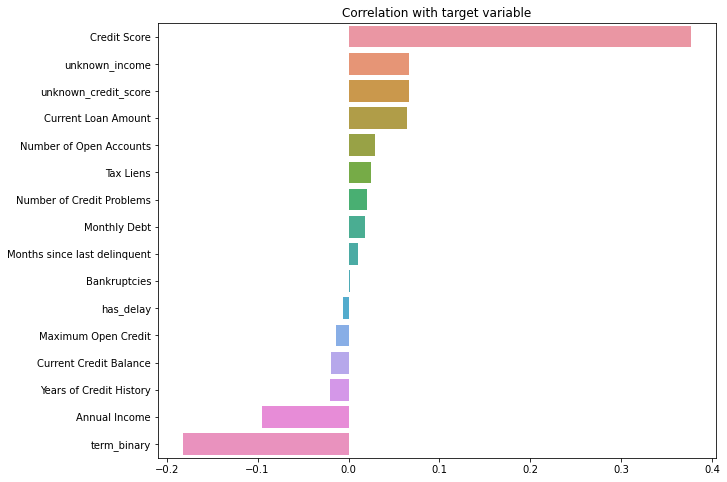

In [46]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [47]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [48]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Подбор моделей, получение бейзлана

In [49]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income,unknown_credit_score,term_binary
0,Own Home,482087.0,4 years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,Short Term,309573.0,47386.0,7914.0,749.0,0,1,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,Short Term,309573.0,308389.0,13651.0,742.0,0,1,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,Short Term,121396.0,95855.0,11338.0,694.0,0,1,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,Short Term,125840.0,93309.0,7180.0,719.0,0,1,0,0,1
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,...,Long Term,337304.0,165680.0,18692.0,731.0,1,1,1,1,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,...,Short Term,309573.0,51623.0,2317.0,745.0,0,1,0,0,1
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,...,Short Term,250888.0,89015.0,19761.0,705.0,1,1,0,0,1
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,...,Short Term,129734.0,19.0,17.0,731.0,0,1,1,1,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,...,Long Term,572880.0,205333.0,17613.0,731.0,1,1,1,1,0


In [50]:
NEW_FEATURE_NAMES

['has_delay', 'unknown_income', 'unknown_credit_score', 'term_binary']

In [51]:
SELECTED_FEATURE_NAMES = NUMB_FEATURE_NAMES + NEW_FEATURE_NAMES


X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=11)

Нормализация

In [52]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMB_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMB_FEATURE_NAMES])

df_train = df_norm.copy()

Балансировка

In [53]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3768
1    2964
Name: Credit Default, dtype: int64

In [54]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

**LogisticRegression**

In [55]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3768
           1       0.63      0.42      0.51      2964

    accuracy                           0.64      6732
   macro avg       0.64      0.61      0.61      6732
weighted avg       0.64      0.64      0.62      6732

TEST

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1619
           1       0.47      0.41      0.44       631

    accuracy                           0.71      2250
   macro avg       0.63      0.62      0.62      2250
weighted avg       0.69      0.71      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1328  291
1                372  259


**k ближайших соседей**

In [56]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3768
           1       0.74      0.67      0.70      2964

    accuracy                           0.75      6732
   macro avg       0.75      0.74      0.74      6732
weighted avg       0.75      0.75      0.75      6732

TEST

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1619
           1       0.35      0.39      0.37       631

    accuracy                           0.62      2250
   macro avg       0.55      0.55      0.55      2250
weighted avg       0.64      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1157  462
1                386  245


**XGBoost**

In [57]:
model_xgb = xgb.XGBClassifier(random_state=11)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3768
           1       0.98      0.98      0.98      2964

    accuracy                           0.98      6732
   macro avg       0.98      0.98      0.98      6732
weighted avg       0.98      0.98      0.98      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1619
           1       0.53      0.45      0.49       631

    accuracy                           0.73      2250
   macro avg       0.66      0.65      0.65      2250
weighted avg       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1365  254
1                346  285


**CatBoost**

In [59]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3768
           1       0.93      0.84      0.88      2964

    accuracy                           0.90      6732
   macro avg       0.91      0.90      0.90      6732
weighted avg       0.90      0.90      0.90      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1619
           1       0.55      0.44      0.49       631

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1389  230
1                355  276


### Выбор наилучшей модели, настройка гиперпараметров

In [60]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=11)

Подбор параметров

In [61]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [62]:
cv=KFold(n_splits=3, random_state=11, shuffle=True)

In [63]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 581 ms, sys: 391 ms, total: 972 ms
Wall time: 9.43 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=11, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fbb88df7220>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [64]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 7}

In [65]:
rs.best_score_

0.5394068539109662

Проверка качества, борьба с переобучением

In [66]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      silent=True, random_state=11)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      3768
           1       0.80      0.62      0.70      2964

    accuracy                           0.77      6732
   macro avg       0.77      0.75      0.75      6732
weighted avg       0.77      0.77      0.76      6732

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1619
           1       0.55      0.48      0.51       631

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1371  248
1                328  303
CPU times: user 2.99 s, sys: 1.92 s, total: 4.91 s
Wall time: 2.04 s


Подготовка тестового датасета

In [67]:
# Добавляется признак has_delay, всем наблюдениям присваивается 1
df_test['has_delay'] = 1

# Заменяется NaN на 0 в 'Months since last delinquent'
df_test['Months since last delinquent'].fillna(0, inplace=True)

# По отсутствующей задолженности присваивается 0 в has_delay
df_test.loc[(df_test['Months since last delinquent'] == 0), 'has_delay'] = 0

# Добавляется признак unknown_income, всем наблюдениям присваивается 0
df_test['unknown_income'] = 0

# В annual_income_median записываеся медианное значение дохода
annual_income_median = df_test['Annual Income'].median()

# В unknown_income по неизвестному доходу присваивается 1 
df_test.loc[(df_test['Annual Income'].isnull()), 'unknown_income'] = 1

# Пропуски дохода заполняются медианными значениями
df_test['Annual Income'].fillna(annual_income_median, inplace=True)

# Добавляется признак unknown_credit_score, всем наблюдениям присваивается 0
df_test['unknown_credit_score'] = 0
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']

# В credit_score_median записываю медианное значение рейтинга
credit_score_median = df_test['Credit Score'].median()

# В unknown_credit_score по неизвестному рейтингу присваивается 1 
df_test.loc[(df_test['Credit Score'].isnull()), 'unknown_credit_score'] = 1

# Пропуски рейтинга заменяются медианными значениями
df_test['Credit Score'].fillna(credit_score_median, inplace=True)

# Уникальные значения поля Years in current job
unique_years_in_current_job = df_test['Years in current job'].unique()

var_experiance = unique_years_in_current_job[1:]

# NaN заменяются рандомными значениями трудового стажа
df_test['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

# 99999999.0 в Current Loan Amount заменяются на медианные
median_current_loan_amount = df_test['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

df_test['term_binary'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [68]:
df_for_model = df_test[SELECTED_FEATURE_NAMES]
df_for_model.head(10)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,has_delay,unknown_income,unknown_credit_score,term_binary
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,6813.0,731.0,1,1,1,1
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,2318.0,699.0,1,0,0,1
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,200178.0,146490.0,18729.0,7260.0,0,0,0,1
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,27559.0,739.0,1,0,0,1
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,777634.0,425391.0,42605.0,706.0,0,0,0,0
5,922583.0,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,94028.0,135508.0,11148.0,679.0,1,0,0,1
6,1233309.0,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,454388.0,292904.0,8181.0,685.0,1,0,0,1
7,1215867.0,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,407726.0,120099.0,7599.0,701.0,1,0,0,1
8,1178475.0,0.0,8.0,9.1,370524.0,0.0,0.0,0.0,131956.0,237747.0,10112.0,731.0,0,1,1,1
9,2140445.0,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,391336.0,294500.0,18372.0,745.0,1,0,0,1


In [69]:
y_pred_output = final_model.predict(df_for_model)

In [70]:
y_pred_output.shape

(2500,)

In [71]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred_output})

In [73]:
RESULT_PATH='./GurbanovIM_predictions.csv'
result.to_csv(RESULT_PATH, index=False)

In [74]:
SAMPLE = './GurbanovIM_predictions.csv'
df_sample = pd.read_csv(SAMPLE)

predictions = pd.DataFrame(index = df_sample['Id'])

predictions[TARGET_NAME] = y_pred_output
predictions

,Credit Default
Id,
0,0
1,0
2,1
3,0
4,0
...,...
2495,0
2496,1
2497,0
